In [1]:
#https://www.datacamp.com/community/tutorials/generative-adversarial-networks
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras import initializers

!pip install image-quality
import imquality.brisque as brisque
import PIL.Image

     |████████████████████████████████| 146 kB 4.4 MB/s 
     |████████████████████████████████| 170 kB 16.6 MB/s 
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp37-cp37m-linux_x86_64.whl size=233360 sha256=6c2361fad32993e605ad223d8219a11487e515cefcc6586781c25ca8a21a42ad
  Stored in directory: /root/.cache/pip/wheels/cd/e8/1e/bf95cf256e4d3ffc94289ab508c49d48e34c98220af63e3513
Successfully built libsvm


In [2]:
# Let Keras know that we are using tensorflow as our backend engine
os.environ["KERAS_BACKEND"] = "tensorflow"

# To make sure that we can reproduce the experiment and get the same results
np.random.seed(10)

# The dimension of our random noise vector.
random_dim = 100

## With the default hyperparameters settings:

In [26]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [27]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [28]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [29]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


--------------- Epoch 0 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.25it/s]


--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.12it/s]


--------------- Epoch 2 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.30it/s]


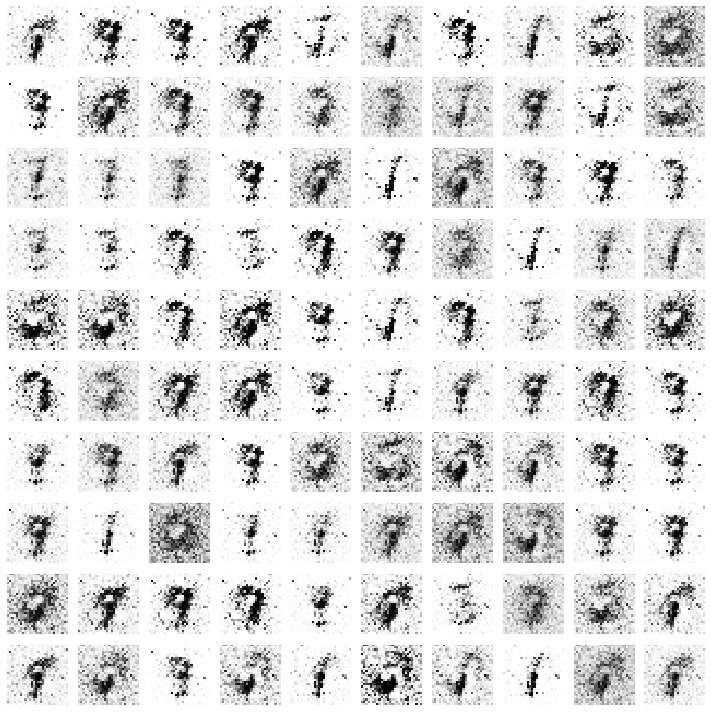

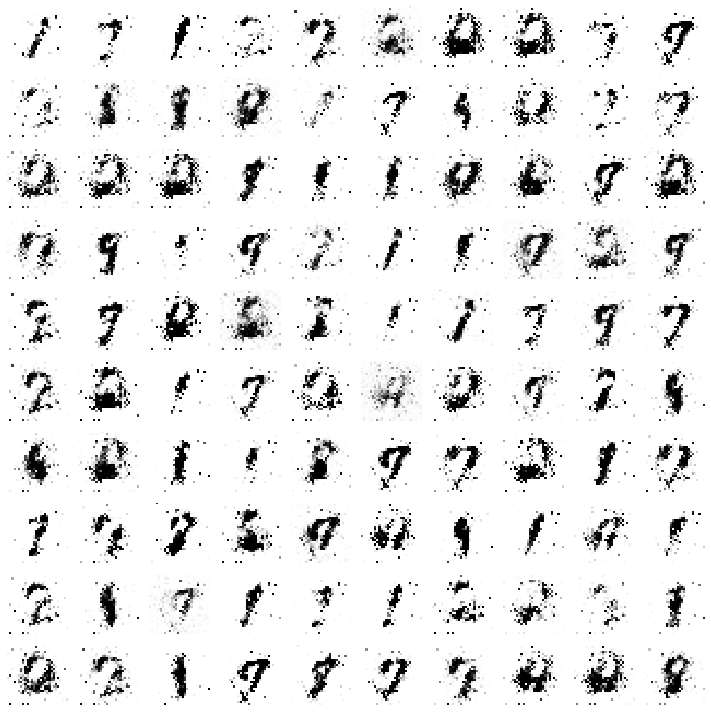

In [30]:
import math
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(math.floor(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

if __name__ == '__main__':
    train(2, 128)

In [32]:
path = '/content/gan_generated_image_epoch_0.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


41.51994862707133

In [33]:
path = '/content/gan_generated_image_epoch_1.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


92.0143123589223

## Without Image normalization

In [34]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    #x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [35]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [36]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [37]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


--------------- Epoch 0 ---------------


100%|██████████| 468/468 [00:41<00:00, 11.28it/s]


--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.20it/s]


--------------- Epoch 2 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.18it/s]


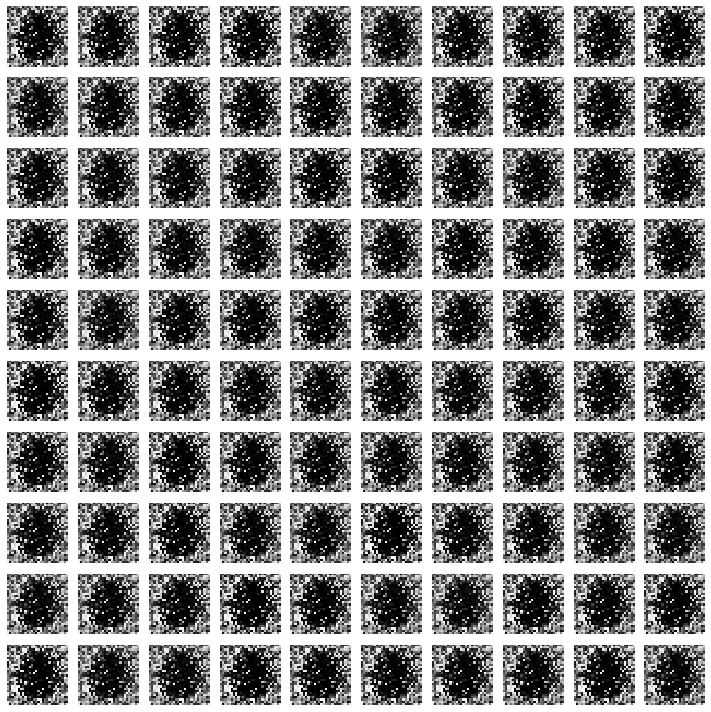

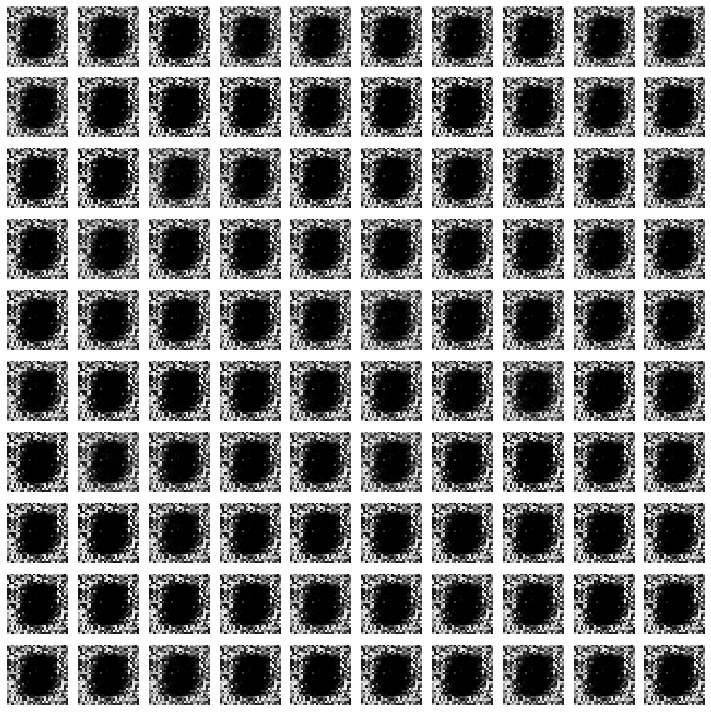

In [38]:
import math
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(math.floor(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

if __name__ == '__main__':
    train(2, 128)

In [39]:
path = '/content/gan_generated_image_epoch_0.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


49.13666057416262

In [40]:
path = '/content/gan_generated_image_epoch_1.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


59.96086288644514

## Changing learning rate to 0.002

In [41]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [42]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [43]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [44]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


--------------- Epoch 0 ---------------


100%|██████████| 468/468 [00:39<00:00, 11.91it/s]


--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.18it/s]


--------------- Epoch 2 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.07it/s]


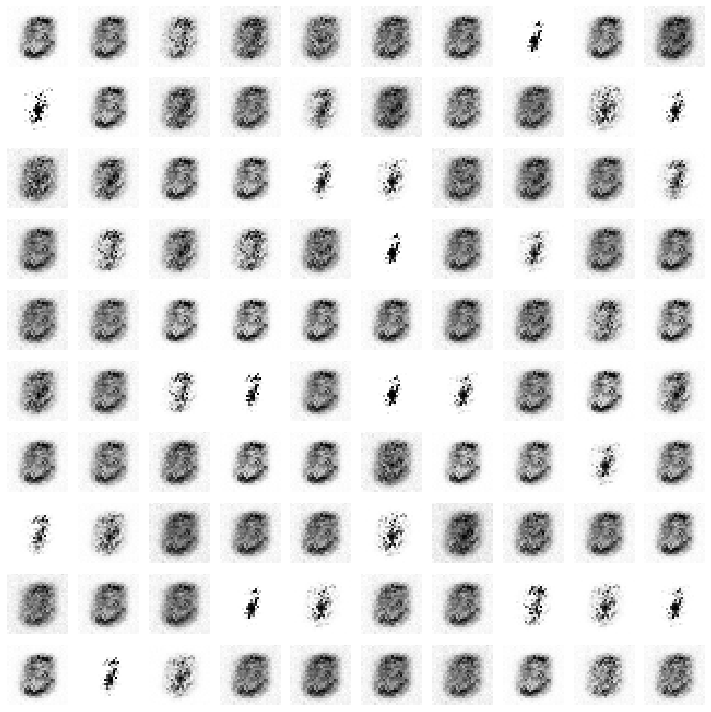

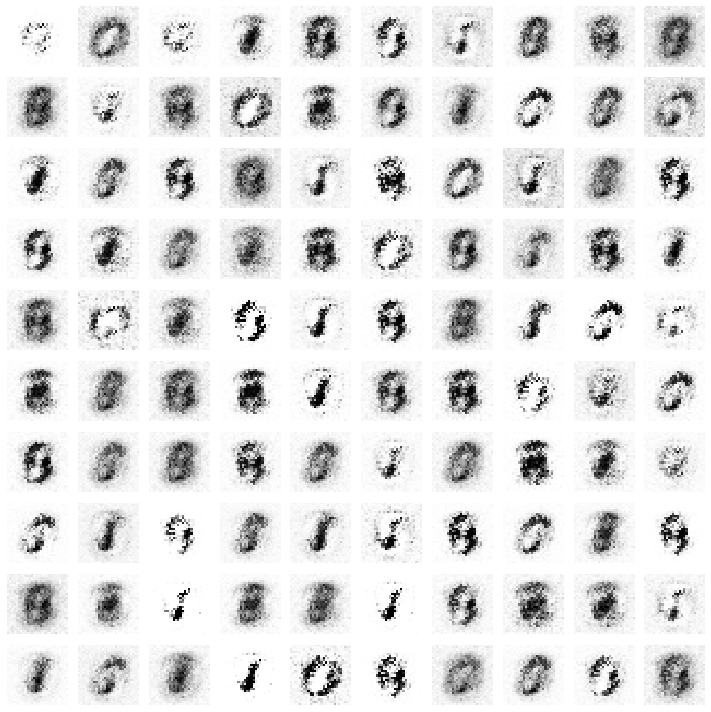

In [45]:
import math
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(math.floor(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

if __name__ == '__main__':
    train(2, 128)

In [46]:
path = '/content/gan_generated_image_epoch_0.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


20.027034642396842

In [47]:
path = '/content/gan_generated_image_epoch_1.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


11.899330620611266

## Changing the learning rate to 0.0001

In [30]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [31]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0001, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [32]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [33]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


--------------- Epoch 0 ---------------


100%|██████████| 468/468 [00:41<00:00, 11.22it/s]


--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:39<00:00, 11.77it/s]


--------------- Epoch 2 ---------------


100%|██████████| 468/468 [00:41<00:00, 11.36it/s]


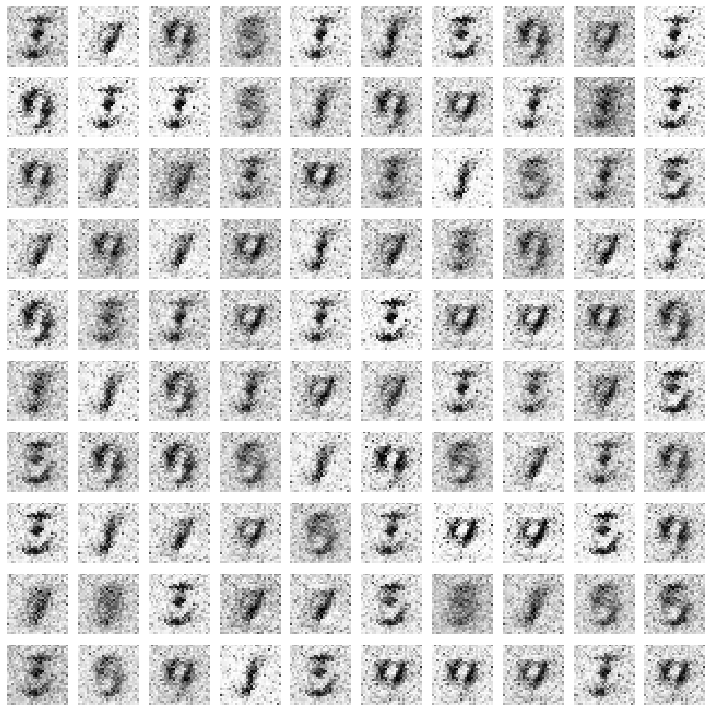

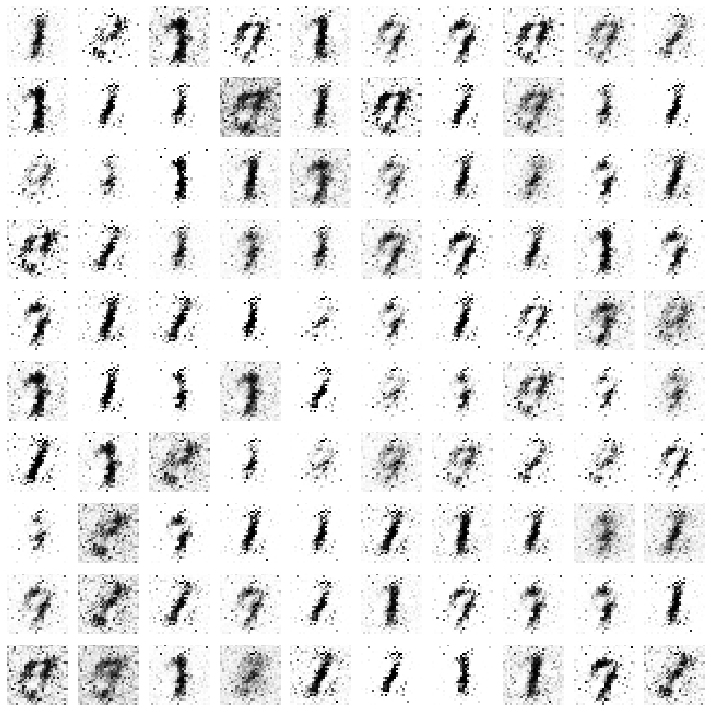

In [34]:
import math
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(math.floor(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

if __name__ == '__main__':
    train(2, 128)

In [35]:
path = '/content/gan_generated_image_epoch_0.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


28.285433004471628

In [36]:
path = '/content/gan_generated_image_epoch_1.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


64.61072942067639

## Changing the beta value to 0.4

In [55]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [56]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.4)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [57]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [58]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


--------------- Epoch 0 ---------------


100%|██████████| 468/468 [00:39<00:00, 11.96it/s]


--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.20it/s]


--------------- Epoch 2 ---------------


100%|██████████| 468/468 [00:37<00:00, 12.55it/s]


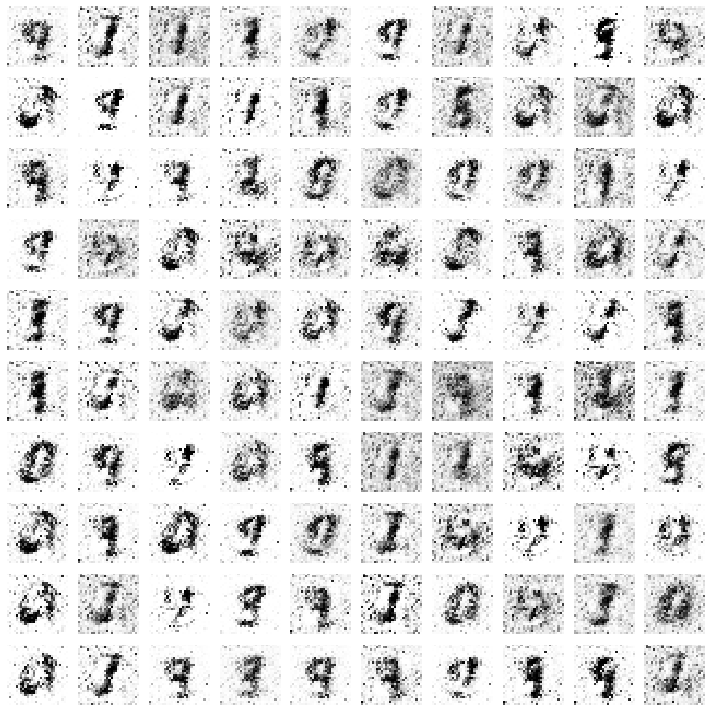

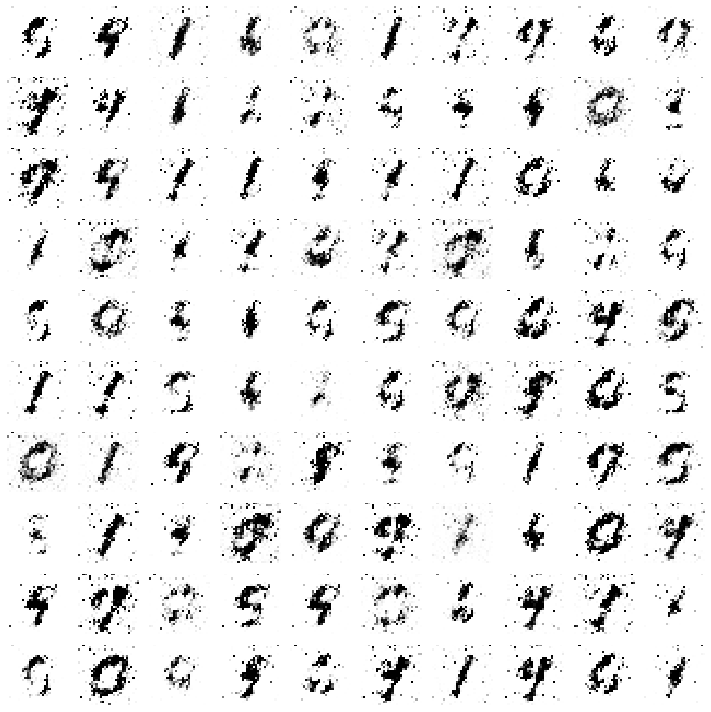

In [59]:
import math
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(math.floor(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

if __name__ == '__main__':
    train(2, 128)

In [60]:
path = '/content/gan_generated_image_epoch_0.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


39.81101242167537

In [61]:
path = '/content/gan_generated_image_epoch_1.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


103.1639907067557

## Changing the beta value to 0.6

In [62]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [63]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.6)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [64]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [65]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


--------------- Epoch 0 ---------------


100%|██████████| 468/468 [00:37<00:00, 12.35it/s]


--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:35<00:00, 13.04it/s]


--------------- Epoch 2 ---------------


100%|██████████| 468/468 [00:36<00:00, 12.69it/s]


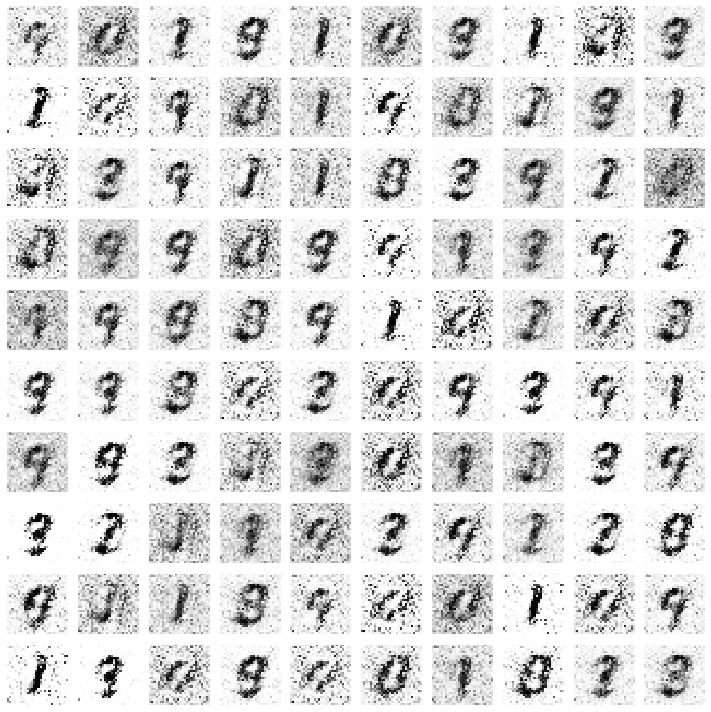

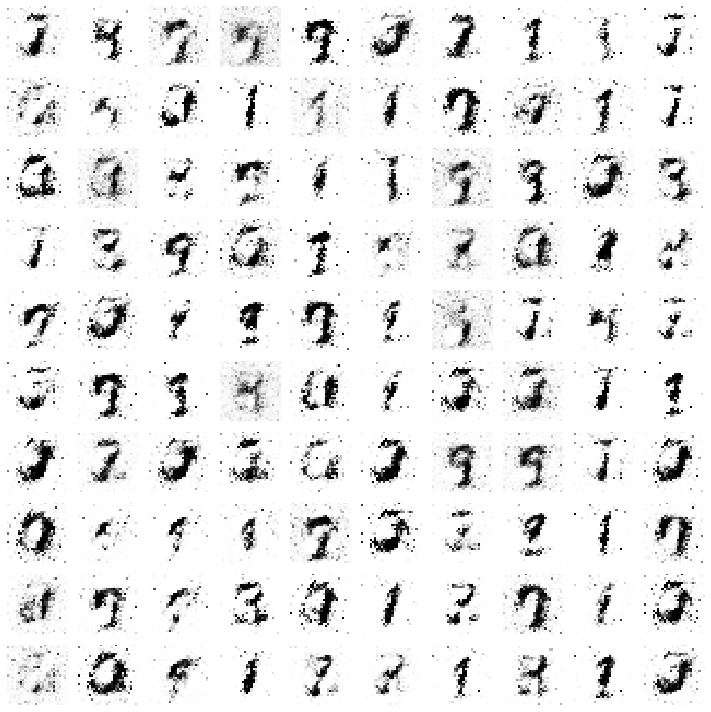

In [66]:
import math
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(math.floor(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

if __name__ == '__main__':
    train(2, 128)

In [67]:
path = '/content/gan_generated_image_epoch_0.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


31.412380543332432

In [68]:
path = '/content/gan_generated_image_epoch_1.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


62.22088277175121

## Changing the beta value to 0.3

In [69]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [70]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.3)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [71]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [72]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


--------------- Epoch 0 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.03it/s]


--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:37<00:00, 12.53it/s]


--------------- Epoch 2 ---------------


100%|██████████| 468/468 [00:39<00:00, 11.91it/s]


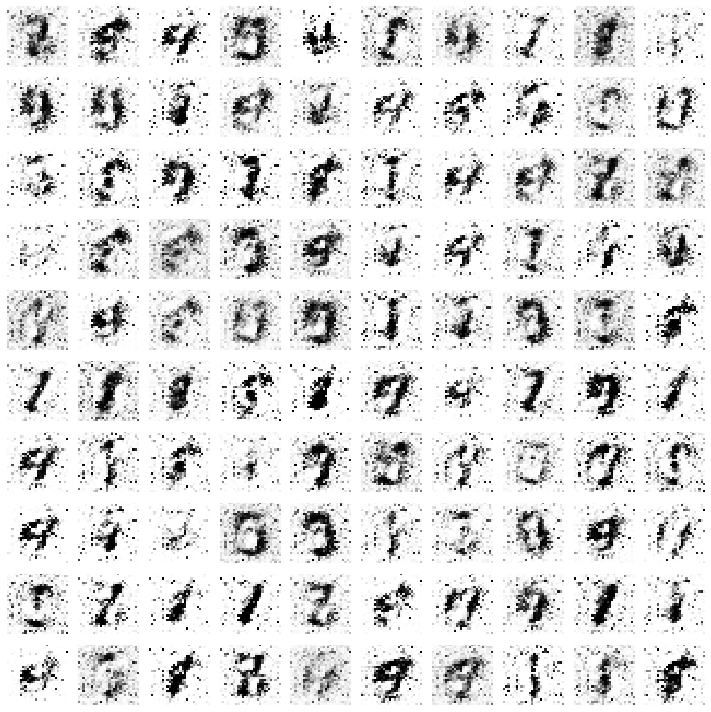

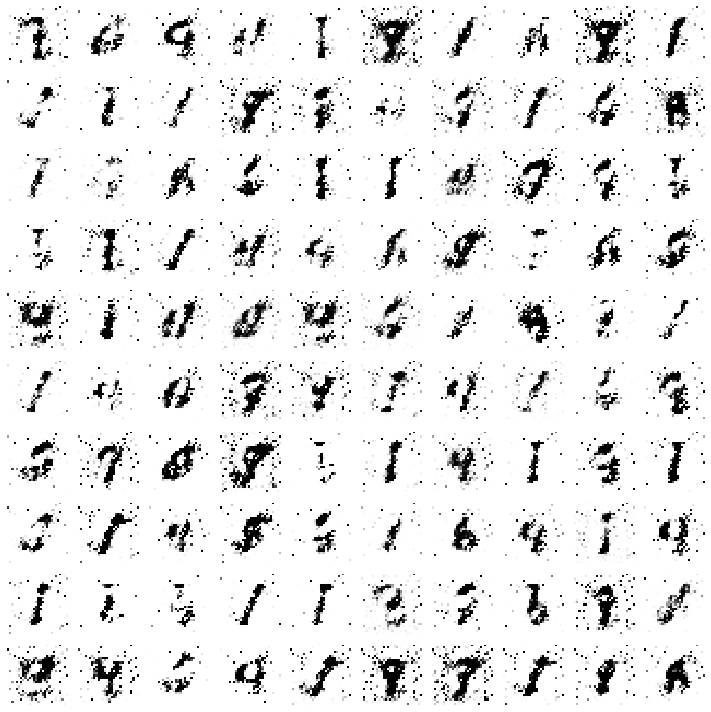

In [73]:
import math
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(math.floor(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

if __name__ == '__main__':
    train(2, 128)

In [74]:
path = '/content/gan_generated_image_epoch_0.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


56.4558444743669

In [75]:
path = '/content/gan_generated_image_epoch_1.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


119.45046681128397

## Changing the no. of layers in generator

In [76]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [77]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(2048))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [78]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [79]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


--------------- Epoch 0 ---------------


100%|██████████| 468/468 [00:41<00:00, 11.35it/s]


--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:39<00:00, 11.93it/s]


--------------- Epoch 2 ---------------


100%|██████████| 468/468 [00:40<00:00, 11.62it/s]


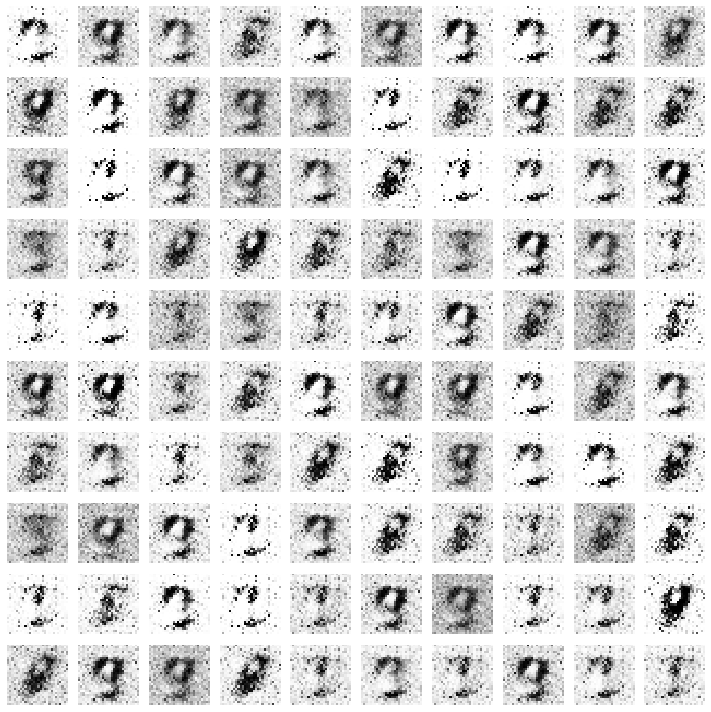

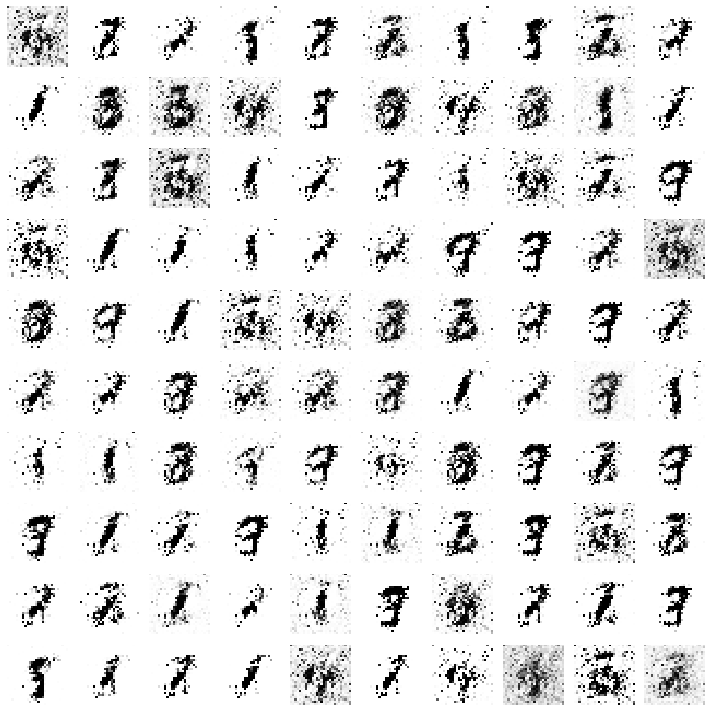

In [80]:
import math
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(math.floor(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

if __name__ == '__main__':
    train(2, 128)

In [81]:
path = '/content/gan_generated_image_epoch_0.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


34.639723623733374

In [82]:
path = '/content/gan_generated_image_epoch_1.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


101.79414878862448

## Changing the no of layers in discriminator

In [83]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [84]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1024))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [85]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [86]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


--------------- Epoch 0 ---------------


100%|██████████| 468/468 [00:43<00:00, 10.77it/s]


--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:40<00:00, 11.55it/s]


--------------- Epoch 2 ---------------


100%|██████████| 468/468 [00:40<00:00, 11.64it/s]


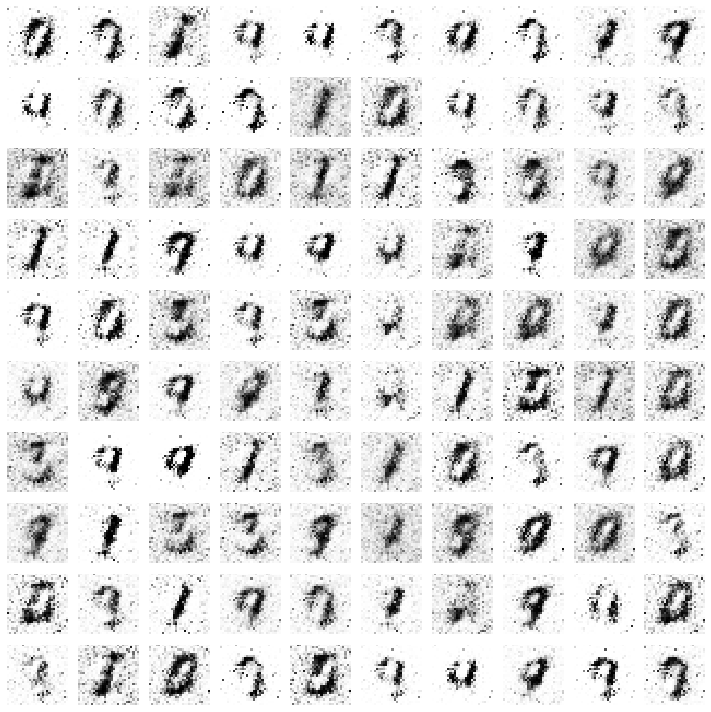

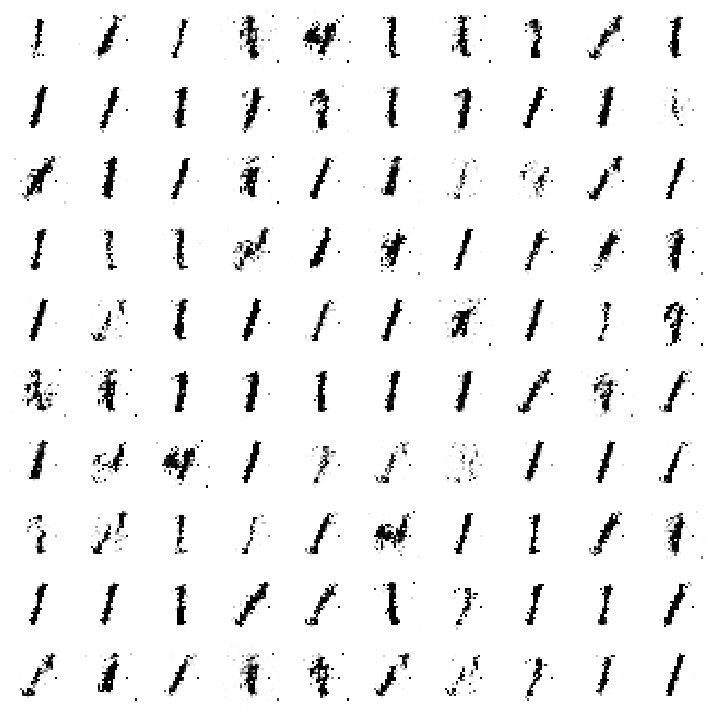

In [87]:
import math
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(math.floor(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

if __name__ == '__main__':
    train(2, 128)

In [88]:
path = '/content/gan_generated_image_epoch_0.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


36.99154608206058

In [89]:
path = '/content/gan_generated_image_epoch_1.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


109.8443080232797

## Changing the no of layers in both the generator and discriminator

In [47]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [48]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(2048))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1024))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [49]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [50]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


--------------- Epoch 0 ---------------


100%|██████████| 468/468 [00:46<00:00, 10.13it/s]


--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:45<00:00, 10.28it/s]


--------------- Epoch 2 ---------------


100%|██████████| 468/468 [00:44<00:00, 10.50it/s]


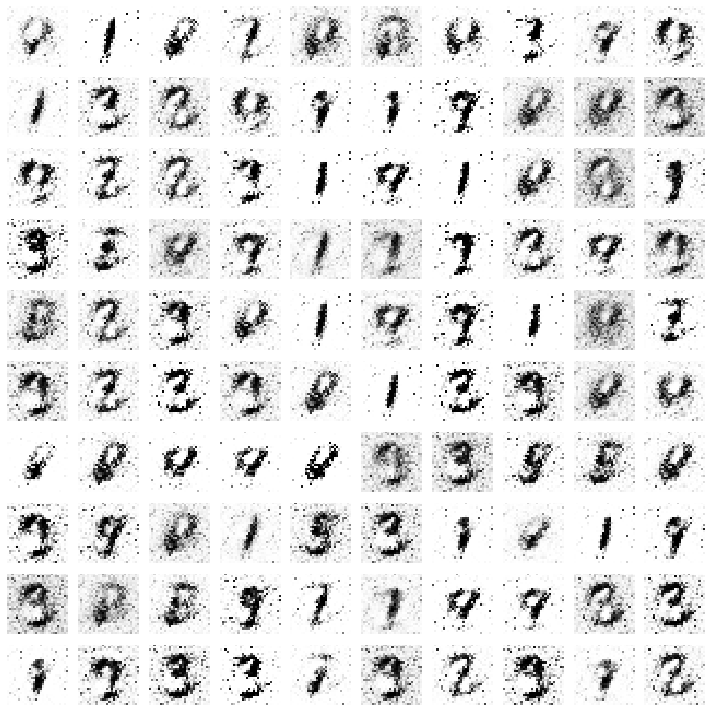

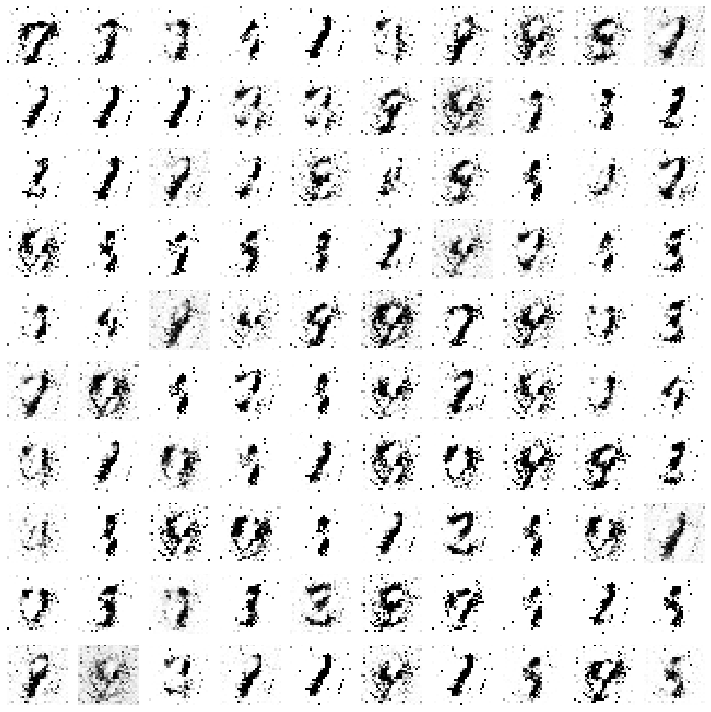

In [51]:
import math
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(math.floor(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

if __name__ == '__main__':
    train(2, 128)

In [52]:
path = '/content/gan_generated_image_epoch_0.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


52.92568474384731

In [53]:
path = '/content/gan_generated_image_epoch_1.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


97.97560787696963

## Changing no of epochs to 4

In [24]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [25]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [26]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [27]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


--------------- Epoch 0 ---------------


100%|██████████| 468/468 [00:41<00:00, 11.36it/s]


--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:40<00:00, 11.57it/s]


--------------- Epoch 2 ---------------


100%|██████████| 468/468 [00:41<00:00, 11.35it/s]


--------------- Epoch 3 ---------------


100%|██████████| 468/468 [00:41<00:00, 11.29it/s]


--------------- Epoch 4 ---------------


100%|██████████| 468/468 [00:42<00:00, 11.09it/s]


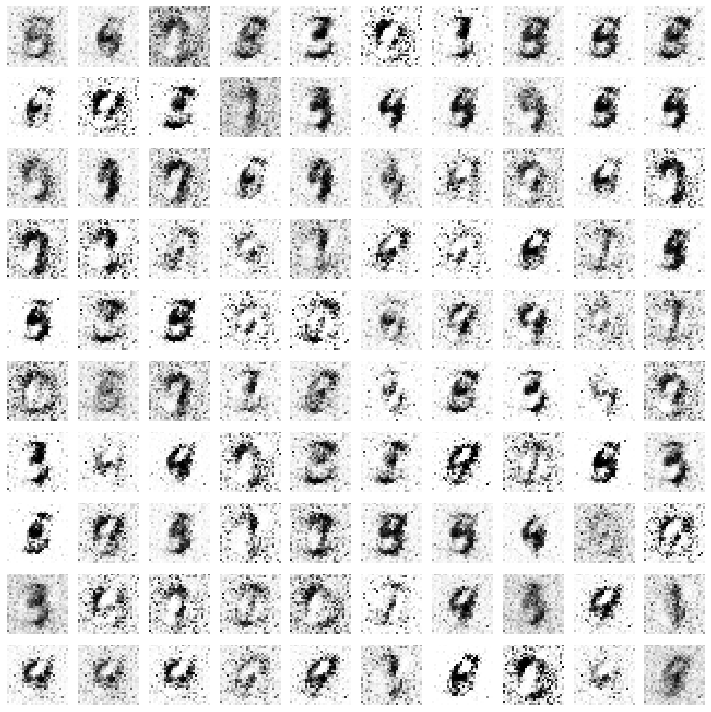

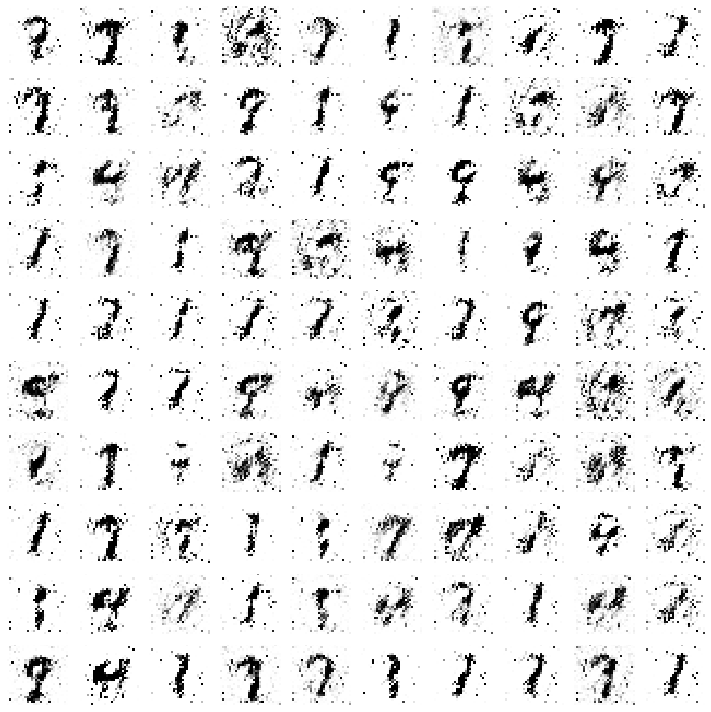

In [29]:
import math
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(epochs+3):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(math.floor(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

if __name__ == '__main__':
    train(2, 128)

In [22]:
path = '/content/gan_generated_image_epoch_0.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


38.62017421805646

In [23]:
path = '/content/gan_generated_image_epoch_1.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


92.9649858645956

## After tuning hyperparameters, choosing the best settings.

In [59]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [60]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.3)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(2048))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1024))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [61]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [62]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


--------------- Epoch 0 ---------------


100%|██████████| 468/468 [00:45<00:00, 10.29it/s]


--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:43<00:00, 10.77it/s]


--------------- Epoch 2 ---------------


100%|██████████| 468/468 [00:43<00:00, 10.72it/s]


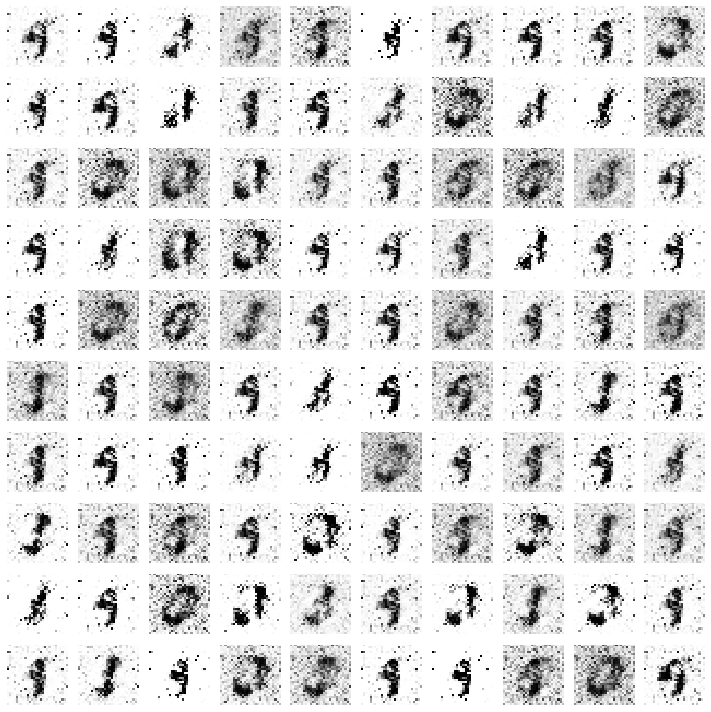

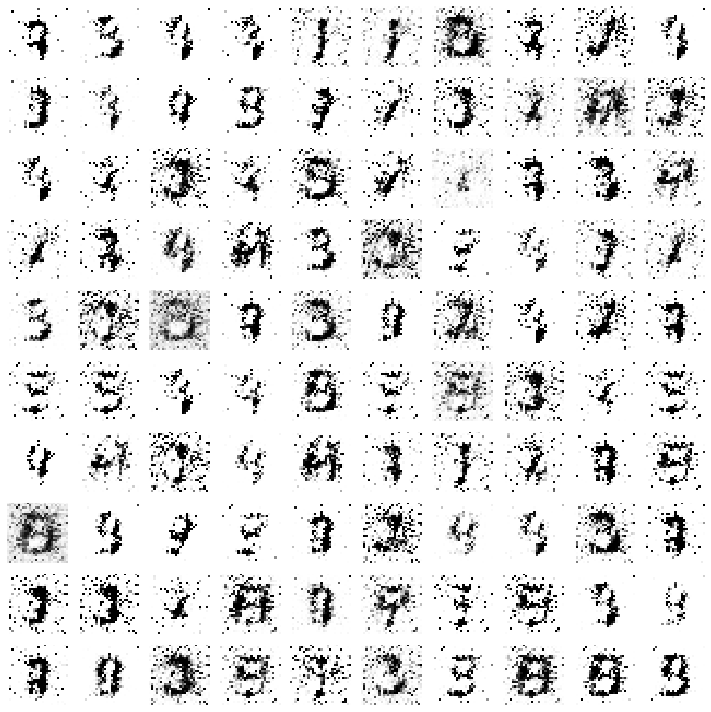

In [63]:
import math
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(math.floor(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

if __name__ == '__main__':
    train(2, 128)

In [64]:
path = '/content/gan_generated_image_epoch_0.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


50.180953208218256

In [65]:
path = '/content/gan_generated_image_epoch_1.png'
img = PIL.Image.open(path)
brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  self.image = skimage.color.rgb2gray(self.image)
/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


113.93490313785045